# NFL Big Data Bowl 2026 - Data Exploration

This notebook explores the NFL tracking data and demonstrates the preprocessing pipeline.

**Contents:**
1. Load and examine raw tracking data
2. Understand data format and features
3. Visualize player movements
4. Explore feature engineering
5. Understand the prediction task

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print('✓ Imports successful')

✓ Imports successful


## 1. Load Sample Data

The NFL Big Data Bowl data consists of:
- **Input data**: Player tracking for observed frames (x, y, speed, direction, etc.)
- **Output data**: Future player positions to predict

In [2]:
# Data paths - adjust to your local setup
DATA_DIR = Path('/mnt/raid0/Kaggle Big Data Bowl/data/raw')  # Update this path

# Load one week of data for exploration
input_file = DATA_DIR / 'input_2023_w01.csv'
output_file = DATA_DIR / 'output_2023_w01.csv'

print(f"Loading data from: {DATA_DIR}")
print(f"Input file: {input_file.name}")
print(f"Output file: {output_file.name}")

# Load data
input_df = pd.read_csv(input_file)
output_df = pd.read_csv(output_file)

print(f"\n✓ Loaded {len(input_df):,} input rows")
print(f"✓ Loaded {len(output_df):,} output rows")

Loading data from: /mnt/raid0/Kaggle Big Data Bowl/data/raw
Input file: input_2023_w01.csv
Output file: output_2023_w01.csv

✓ Loaded 285,714 input rows
✓ Loaded 32,088 output rows


## 2. Examine Data Structure

In [3]:
# Input data structure
print("=" * 80)
print("INPUT DATA (Observed Frames)")
print("=" * 80)
print(f"\nShape: {input_df.shape}")
print(f"\nColumns ({len(input_df.columns)}):")
print(input_df.columns.tolist())
print(f"\nFirst few rows:")
input_df.head()

INPUT DATA (Observed Frames)

Shape: (285714, 23)

Columns (23):
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

First few rows:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [4]:
# Output data structure
print("=" * 80)
print("OUTPUT DATA (Future Frames to Predict)")
print("=" * 80)
print(f"\nShape: {output_df.shape}")
print(f"\nColumns ({len(output_df.columns)}):")
print(output_df.columns.tolist())
print(f"\nFirst few rows:")
output_df.head()

OUTPUT DATA (Future Frames to Predict)

Shape: (32088, 6)

Columns (6):
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

First few rows:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [5]:
# Key columns explained
print("KEY COLUMNS:")
print("\nIdentifiers:")
print("  game_id:    Unique game identifier")
print("  play_id:    Unique play within game")
print("  nfl_id:     Unique player identifier")
print("  frame_id:   Frame number in sequence")

print("\nTracking Data:")
print("  x:          X coordinate (0-120 yards)")
print("  y:          Y coordinate (0-53.3 yards)")
print("  s:          Speed (yards/second)")
print("  a:          Acceleration (yards/second^2)")
print("  dir:        Direction of movement (0-360 degrees)")
print("  o:          Orientation/body angle (0-360 degrees)")

print("\nPlayer Info:")
print("  player_position: Position (QB, WR, RB, etc.)")
print("  player_side:     Offense/Defense")
print("  player_role:     Role in play (Passer, Targeted Receiver, etc.)")
print("  player_height:   Height")
print("  player_weight:   Weight")

print("\nGame Context:")
print("  down:            Down (1-4)")
print("  yardsToGo:       Yards to first down")
print("  ball_land_x:     Where ball will land")
print("  ball_land_y:     Where ball will land")

KEY COLUMNS:

Identifiers:
  game_id:    Unique game identifier
  play_id:    Unique play within game
  nfl_id:     Unique player identifier
  frame_id:   Frame number in sequence

Tracking Data:
  x:          X coordinate (0-120 yards)
  y:          Y coordinate (0-53.3 yards)
  s:          Speed (yards/second)
  a:          Acceleration (yards/second^2)
  dir:        Direction of movement (0-360 degrees)
  o:          Orientation/body angle (0-360 degrees)

Player Info:
  player_position: Position (QB, WR, RB, etc.)
  player_side:     Offense/Defense
  player_role:     Role in play (Passer, Targeted Receiver, etc.)
  player_height:   Height
  player_weight:   Weight

Game Context:
  down:            Down (1-4)
  yardsToGo:       Yards to first down
  ball_land_x:     Where ball will land
  ball_land_y:     Where ball will land


## 3. Data Statistics

In [6]:
# Unique counts
print("DATA SUMMARY:")
print(f"\nUnique games:  {input_df['game_id'].nunique():,}")
print(f"Unique plays:  {input_df.groupby(['game_id', 'play_id']).ngroups:,}")
print(f"Unique players: {input_df['nfl_id'].nunique():,}")

# Frames per play
frames_per_play = input_df.groupby(['game_id', 'play_id'])['frame_id'].max()
print(f"\nFrames per play (input):")
print(f"  Mean:   {frames_per_play.mean():.1f}")
print(f"  Median: {frames_per_play.median():.1f}")
print(f"  Min:    {frames_per_play.min()}")
print(f"  Max:    {frames_per_play.max()}")

# Players per play
players_per_play = input_df.groupby(['game_id', 'play_id'])['nfl_id'].nunique()
print(f"\nPlayers per play:")
print(f"  Mean:   {players_per_play.mean():.1f}")
print(f"  Median: {players_per_play.median():.1f}")
print(f"  Min:    {players_per_play.min()}")
print(f"  Max:    {players_per_play.max()}")

DATA SUMMARY:

Unique games:  16
Unique plays:  819
Unique players: 737

Frames per play (input):
  Mean:   28.3
  Median: 27.0
  Min:    9
  Max:    74

Players per play:
  Mean:   12.3
  Median: 13.0
  Min:    6
  Max:    14



PLAYER POSITIONS:
player_position
WR     146
CB     117
TE      86
RB      81
FS      61
OLB     59
SS      43
ILB     41
QB      35
MLB     27
DE      26
FB       9
DT       3
NT       2
S        1
Name: count, dtype: int64


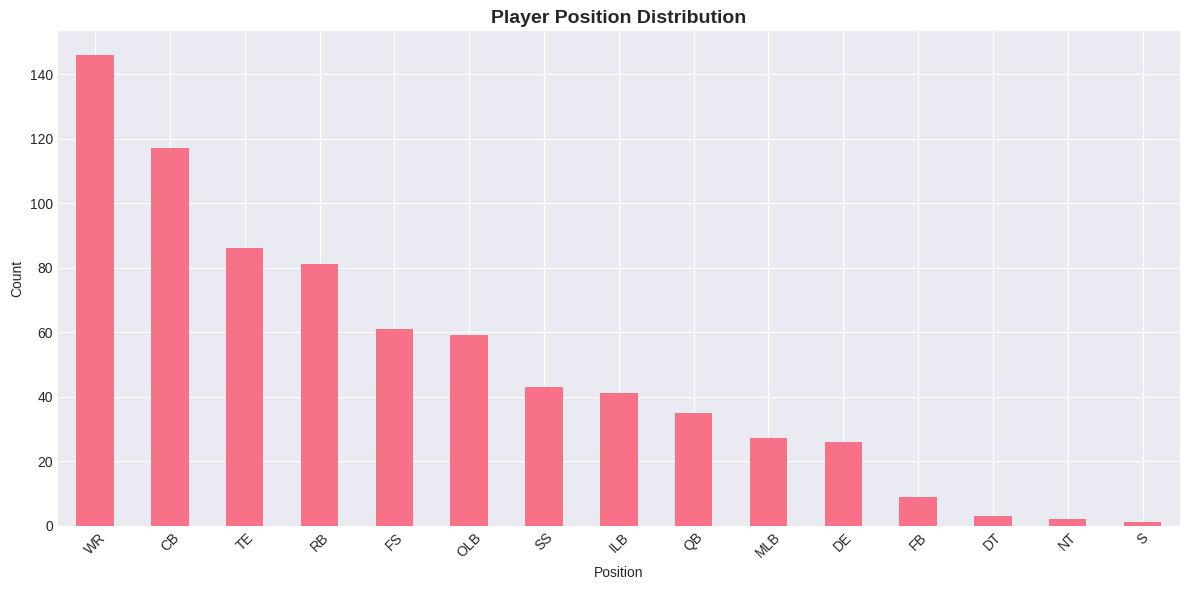

In [7]:
# Position distribution
print("\nPLAYER POSITIONS:")
position_counts = input_df.groupby('nfl_id')['player_position'].first().value_counts()
print(position_counts)

# Plot
plt.figure(figsize=(12, 6))
position_counts.plot(kind='bar')
plt.title('Player Position Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Visualize a Sample Play

Let's visualize player movements for one play.

In [8]:
# Select a random play
sample_game = input_df['game_id'].iloc[0]
sample_play = input_df[input_df['game_id'] == sample_game]['play_id'].iloc[0]

print(f"Visualizing: Game {sample_game}, Play {sample_play}")

# Get play data
play_input = input_df[(input_df['game_id'] == sample_game) & 
                       (input_df['play_id'] == sample_play)].copy()
play_output = output_df[(output_df['game_id'] == sample_game) & 
                         (output_df['play_id'] == sample_play)].copy()

print(f"\nInput frames: {play_input['frame_id'].nunique()}")
print(f"Output frames: {play_output['frame_id'].nunique()}")
print(f"Players: {play_input['nfl_id'].nunique()}")

Visualizing: Game 2023090700, Play 101

Input frames: 26
Output frames: 21
Players: 9


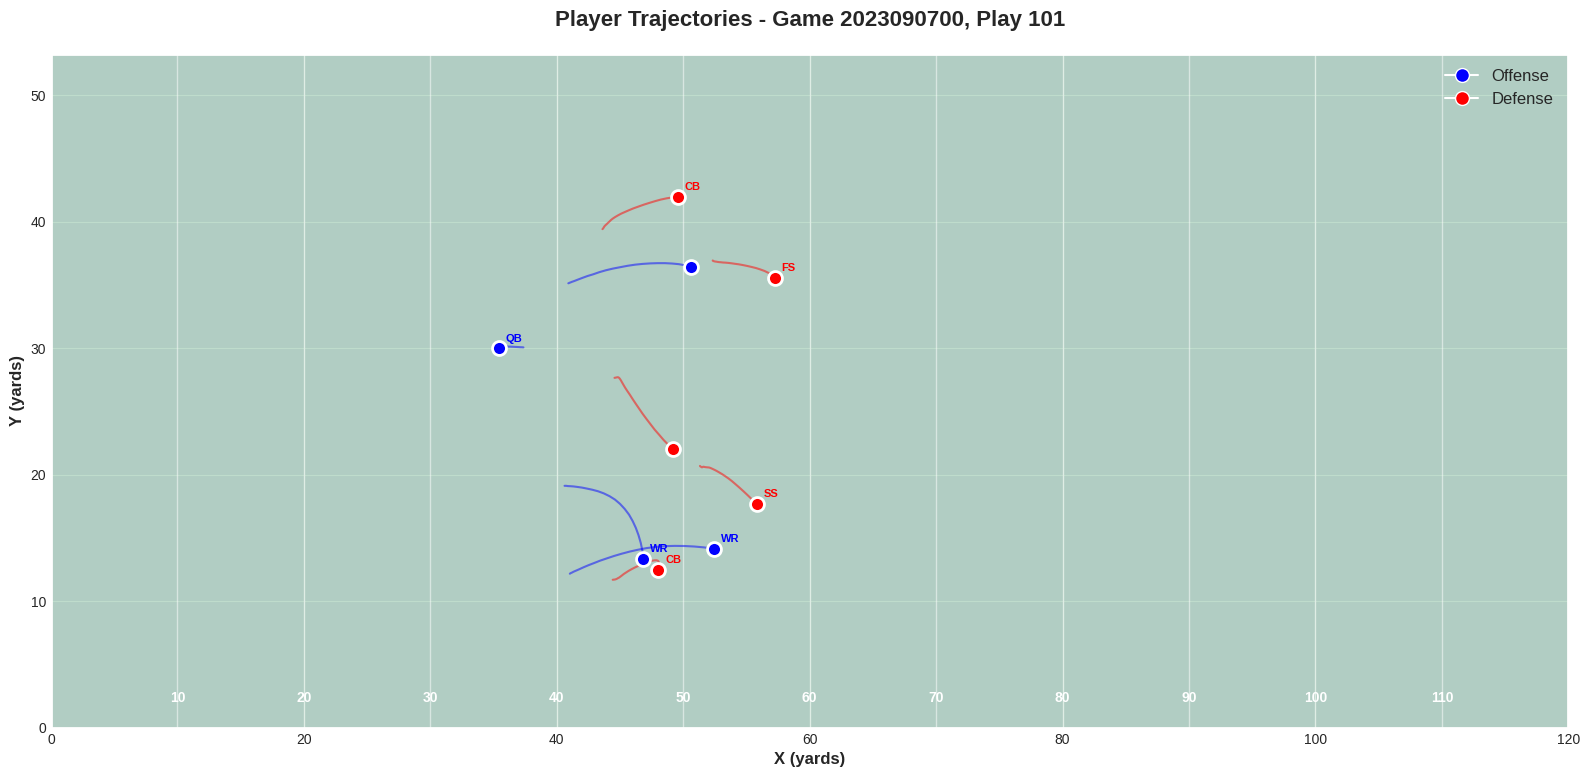


✓ Visualization complete

Legend:
  Blue = Offense
  Red = Defense
  Lines show movement history (input frames)
  Dots show last observed position


In [9]:
def plot_football_field(ax=None):
    """Draw a football field"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    # Field dimensions
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    
    # Field color
    ax.add_patch(plt.Rectangle((0, 0), 120, 53.3, facecolor='#2E8B57', alpha=0.3))
    
    # Yard lines (every 10 yards)
    for x in range(10, 111, 10):
        ax.axvline(x, color='white', linewidth=1, alpha=0.5)
        ax.text(x, 2, str(x), ha='center', color='white', fontsize=10, fontweight='bold')
    
    # Sidelines
    ax.axhline(0, color='white', linewidth=2)
    ax.axhline(53.3, color='white', linewidth=2)
    ax.axvline(0, color='white', linewidth=2)
    ax.axvline(120, color='white', linewidth=2)
    
    ax.set_xlabel('X (yards)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (yards)', fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    
    return ax

# Plot play trajectory
fig, ax = plt.subplots(figsize=(16, 8))
ax = plot_football_field(ax)

# Get last frame of input (starting positions)
last_input_frame = play_input['frame_id'].max()
start_positions = play_input[play_input['frame_id'] == last_input_frame]

# Plot trajectories for each player
for nfl_id in play_input['nfl_id'].unique():
    player_data = play_input[play_input['nfl_id'] == nfl_id].sort_values('frame_id')
    
    # Get player info
    side = player_data['player_side'].iloc[0]
    position = player_data['player_position'].iloc[0]
    
    # Color by side
    color = 'blue' if side == 'Offense' else 'red'
    
    # Plot trajectory (input frames)
    ax.plot(player_data['x'], player_data['y'], 
            color=color, alpha=0.5, linewidth=1.5)
    
    # Plot starting position
    ax.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1], 
               c=color, s=100, edgecolors='white', linewidth=2, zorder=10)
    
    # Label key positions
    if position in ['QB', 'WR', 'CB', 'FS', 'SS']:
        ax.annotate(position, 
                    (player_data['x'].iloc[-1], player_data['y'].iloc[-1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold', color=color)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
           markersize=10, label='Offense'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, label='Defense')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

ax.set_title(f'Player Trajectories - Game {sample_game}, Play {sample_play}', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")
print("\nLegend:")
print("  Blue = Offense")
print("  Red = Defense")
print("  Lines show movement history (input frames)")
print("  Dots show last observed position")

## 5. Feature Engineering Examples

Let's compute some derived features used in our models.

In [10]:
def add_velocity_features(df):
    """Add velocity_x and velocity_y from speed and direction"""
    df = df.copy()
    
    # Convert direction to radians
    dir_rad = np.deg2rad(df['dir'].fillna(0))
    
    # Compute velocity components
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    
    return df

def add_distance_to_ball(df):
    """Add distance to ball landing position"""
    df = df.copy()
    
    if 'ball_land_x' in df.columns:
        dx = df['ball_land_x'] - df['x']
        dy = df['ball_land_y'] - df['y']
        df['distance_to_ball'] = np.sqrt(dx**2 + dy**2)
        df['angle_to_ball'] = np.arctan2(dy, dx)
    
    return df

# Apply feature engineering
input_df_fe = add_velocity_features(input_df)
input_df_fe = add_distance_to_ball(input_df_fe)

print("Added features:")
print("  ✓ velocity_x, velocity_y")
print("  ✓ distance_to_ball, angle_to_ball")

# Show sample
print("\nSample with new features:")
input_df_fe[['x', 'y', 's', 'dir', 'velocity_x', 'velocity_y', 
              'distance_to_ball', 'angle_to_ball']].head(10)

Added features:
  ✓ velocity_x, velocity_y
  ✓ distance_to_ball, angle_to_ball

Sample with new features:


,x,y,s,dir,velocity_x,velocity_y,distance_to_ball,angle_to_ball
0,52.33,36.94,0.09,322.40,-0.054913,0.071306,38.734099,-1.284730
1,52.33,36.94,0.04,200.89,-0.014263,-0.037371,38.734099,-1.284730
2,52.33,36.93,0.12,147.55,0.064388,-0.101263,38.724506,-1.284657
3,52.35,36.92,0.23,131.40,0.172526,-0.152102,38.709271,-1.285080
4,52.37,36.90,0.35,123.26,0.292667,-0.191954,38.684447,-1.285431
5,52.44,36.88,0.60,106.89,0.574119,-0.174321,38.645600,-1.287023
6,52.51,36.86,0.76,103.87,0.737840,-0.182187,38.606850,-1.288619
7,52.60,36.85,0.91,100.97,0.893372,-0.173168,38.572276,-1.290787
8,52.71,36.83,1.10,98.15,1.088890,-0.155942,38.522785,-1.293388
9,52.84,36.81,1.32,96.73,1.310904,-0.154692,38.468133,-1.296496


## 6. Distribution Analysis

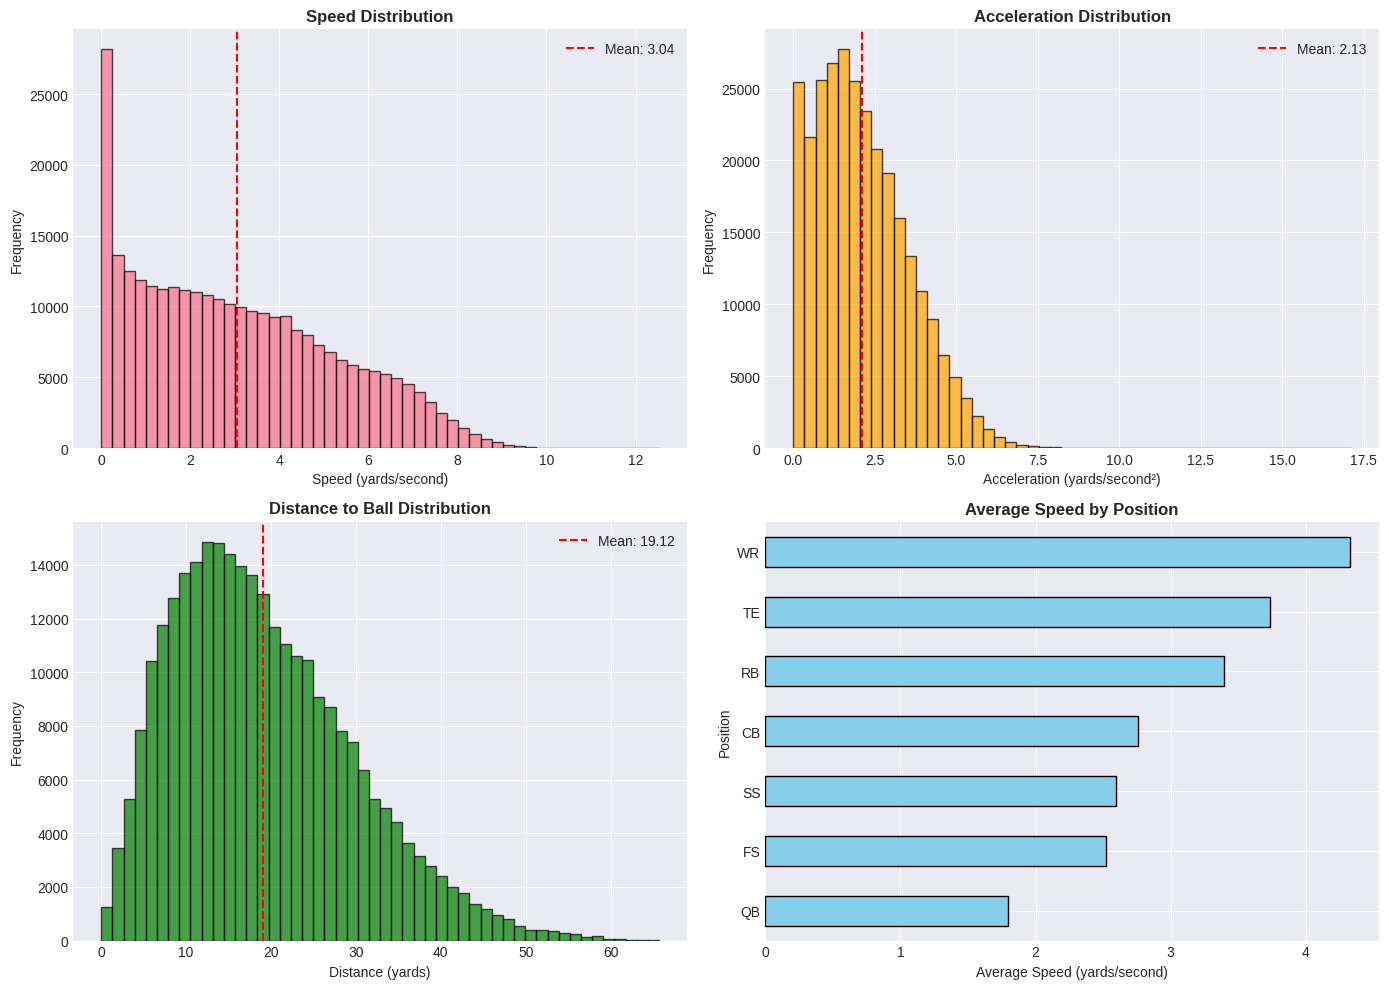

In [11]:
# Speed distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Speed
axes[0, 0].hist(input_df['s'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Speed Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Speed (yards/second)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(input_df['s'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {input_df["s"].mean():.2f}')
axes[0, 0].legend()

# Acceleration
axes[0, 1].hist(input_df['a'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Acceleration Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Acceleration (yards/second²)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(input_df['a'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {input_df["a"].mean():.2f}')
axes[0, 1].legend()

# Distance to ball
if 'distance_to_ball' in input_df_fe.columns:
    axes[1, 0].hist(input_df_fe['distance_to_ball'].dropna(), bins=50, 
                     edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].set_title('Distance to Ball Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Distance (yards)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(input_df_fe['distance_to_ball'].mean(), color='red', 
                        linestyle='--', label=f'Mean: {input_df_fe["distance_to_ball"].mean():.2f}')
    axes[1, 0].legend()

# Speed by position
positions_to_plot = ['QB', 'WR', 'RB', 'TE', 'CB', 'SS', 'FS', 'LB']
speed_by_pos = input_df[input_df['player_position'].isin(positions_to_plot)].groupby('player_position')['s'].mean().sort_values()
speed_by_pos.plot(kind='barh', ax=axes[1, 1], color='skyblue', edgecolor='black')
axes[1, 1].set_title('Average Speed by Position', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Speed (yards/second)')
axes[1, 1].set_ylabel('Position')

plt.tight_layout()
plt.show()

## 7. Understanding the Prediction Task

In [12]:
print("PREDICTION TASK:")
print("=" * 80)
print("\nGiven:")
print("  - Historical tracking data for all 22 players")
print("  - Typically 8-10 frames of history (0.8-1.0 seconds at 10 fps)")
print("  - Player attributes, game context, ball landing position")

print("\nPredict:")
print("  - Future (x, y) positions for all 22 players")
print("  - Variable horizon (typically 3-10 seconds into future)")
print("  - One prediction per frame for each player")

print("\nEvaluation Metric:")
print("  - RMSE (Root Mean Squared Error) on (x, y) coordinates")
print("  - Lower is better")
print("  - Best models achieve ~0.54-0.55 RMSE")

# Show sample prediction format
print("\nExample Output Format:")
print(output_df[['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']].head(10))

PREDICTION TASK:

Given:
  - Historical tracking data for all 22 players
  - Typically 8-10 frames of history (0.8-1.0 seconds at 10 fps)
  - Player attributes, game context, ball landing position

Predict:
  - Future (x, y) positions for all 22 players
  - Variable horizon (typically 3-10 seconds into future)
  - One prediction per frame for each player

Evaluation Metric:
  - RMSE (Root Mean Squared Error) on (x, y) coordinates
  - Lower is better
  - Best models achieve ~0.54-0.55 RMSE

Example Output Format:
      game_id  play_id  nfl_id  frame_id      x      y
0  2023090700      101   46137         1  56.22  17.28
1  2023090700      101   46137         2  56.63  16.88
2  2023090700      101   46137         3  57.06  16.46
3  2023090700      101   46137         4  57.48  16.02
4  2023090700      101   46137         5  57.91  15.56
5  2023090700      101   46137         6  58.34  15.10
6  2023090700      101   46137         7  58.75  14.57
7  2023090700      101   46137         8  

## 8. Data Augmentation Preview

Our models use horizontal flip augmentation during training.

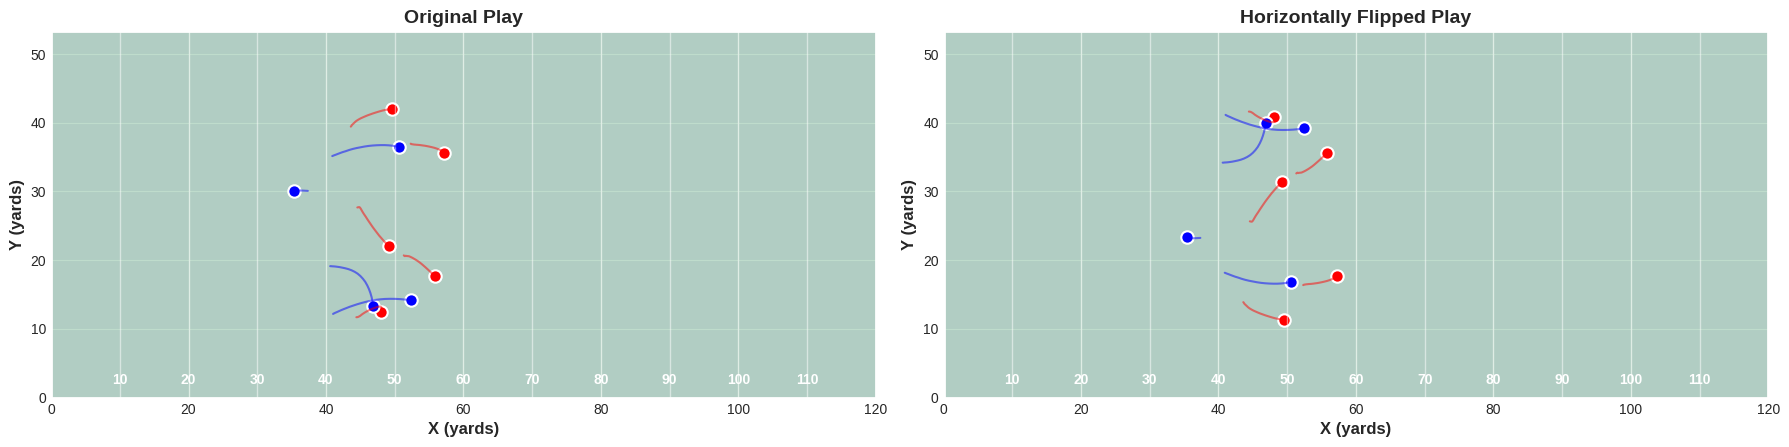


✓ Horizontal flip augmentation

This augmentation:
  - Doubles the training data
  - Improves model generalization
  - Achieves ~0.007 improvement in RMSE


In [13]:
def horizontal_flip(df):
    """Flip play horizontally across field width"""
    df = df.copy()
    field_width = 53.3
    
    # Flip y-coordinate
    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    
    # Flip y-velocity
    for col in ['velocity_y', 'acceleration_y']:
        if col in df.columns:
            df[col] = -df[col]
    
    # Flip direction angles
    if 'dir' in df.columns:
        df['dir'] = (180 - df['dir']) % 360
    if 'o' in df.columns:
        df['o'] = (180 - df['o']) % 360
    
    return df

# Apply flip to sample play
play_flipped = horizontal_flip(play_input)

# Visualize original vs flipped
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original
ax1 = plot_football_field(ax1)
for nfl_id in play_input['nfl_id'].unique():
    player_data = play_input[play_input['nfl_id'] == nfl_id].sort_values('frame_id')
    side = player_data['player_side'].iloc[0]
    color = 'blue' if side == 'Offense' else 'red'
    ax1.plot(player_data['x'], player_data['y'], color=color, alpha=0.5)
    ax1.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1], 
                c=color, s=80, edgecolors='white', linewidth=1.5)
ax1.set_title('Original Play', fontsize=14, fontweight='bold')

# Flipped
ax2 = plot_football_field(ax2)
for nfl_id in play_flipped['nfl_id'].unique():
    player_data = play_flipped[play_flipped['nfl_id'] == nfl_id].sort_values('frame_id')
    side = player_data['player_side'].iloc[0]
    color = 'blue' if side == 'Offense' else 'red'
    ax2.plot(player_data['x'], player_data['y'], color=color, alpha=0.5)
    ax2.scatter(player_data['x'].iloc[-1], player_data['y'].iloc[-1], 
                c=color, s=80, edgecolors='white', linewidth=1.5)
ax2.set_title('Horizontally Flipped Play', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Horizontal flip augmentation")
print("\nThis augmentation:")
print("  - Doubles the training data")
print("  - Improves model generalization")
print("  - Achieves ~0.007 improvement in RMSE")

## Summary

In this notebook, we:

1. ✅ Loaded and examined NFL tracking data
2. ✅ Understood the data format (input/output structure)
3. ✅ Visualized player movements on a football field
4. ✅ Explored feature engineering (velocity, distance to ball)
5. ✅ Analyzed feature distributions
6. ✅ Understood the prediction task
7. ✅ Previewed data augmentation (horizontal flip)

**Next Steps:**
- See `02_st_transformer_training.ipynb` to learn how to train models
- See `03_inference_ensemble.ipynb` to make predictions with pretrained models